# Customer Issue Analysis with SVM


<div style="text-align: right;">copyright(c) 2016</div>
<div style="text-align: right;">version 2.1</div>
<div style="text-align: right;">Clinton Yourth</div>


### ToDo:

> use genetic algorithm to optimize the penalty parameter C of the error term against the number of support vectors 

### Assumptions:

> using SVM with specific restrictions:

>> The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples


### Supporting Documentation

> [wikipedia: support vector machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine)

> [wikipedia: confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

> tool docs:

>> [numpy functions](https://docs.scipy.org/doc/numpy/reference/routines.html)

>> [panda functions](http://pandas.pydata.org/pandas-docs/stable/api.html)

> scikit-learn docs:

>> Support Vector Classifier (SVC):

>>> [SVC classes](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)

>>> [C-SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

>>> [linear SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

>>> [SVC examples](http://scikit-learn.org/stable/modules/svm.html#svm)

>> [metrics.classification.report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

>> [metrics.confusion.matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

> articles:

>> [Influence of C in SVM with Linear Kernel](http://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel)


In [1]:
# jupyter magic settings
%matplotlib inline

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sklearn
from sklearn import preprocessing
import matplotlib as matplotlib
import matplotlib.pyplot as plt

print "python:", sys.version 
print "numpy:", np.__version__
print "pandas:", pd.__version__
print "scipy:", sp.__version__
print "scikit-learn:", sklearn.__version__
print "matplotlib:", matplotlib.__version__

python: 2.7.12 |Anaconda 2.4.1 (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy: 1.11.2
pandas: 0.18.1
scipy: 0.18.1
scikit-learn: 0.18.1
matplotlib: 1.5.1


In [3]:
# import required SVM modules
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import metrics

In [4]:
# converter for missing data
convertMissing = lambda x: float(x.strip()) if x.lstrip('-').replace('.','',1).isdigit() else np.nan

In [5]:
# read customer issues into dataframe(df)
df = pd.read_csv('customer_issues.csv', 
                 index_col=False, 
                 header=0,
                 converters={'F1':convertMissing, 
                             'F2':convertMissing, 
                             'F3':convertMissing, 
                             'F4':convertMissing,
                             'F5':convertMissing,
                             'Target':convertMissing});
df.head()

,F1,F2,F3,F4,F5,Target
0,-0.730174,NaN,-1.986252,-0.754304,-1.236121,NaN
1,-2.854402,NaN,NaN,1.576816,-0.188037,NaN
2,-0.653327,0.024698,1.724892,1.996695,-0.653384,2.0
3,1.105122,1.798437,2.618784,-0.259024,-2.282597,NaN
4,-5.667768,0.080978,-2.586293,0.071860,-3.035848,1.0


In [6]:
# show raw dataframe shape
df.shape

(1000, 6)

In [7]:
# show the number of records with NaN
df[df.isnull().any(axis=1)]

,F1,F2,F3,F4,F5,Target
0,-0.730174,NaN,-1.986252,-0.754304,-1.236121,NaN
1,-2.854402,NaN,NaN,1.576816,-0.188037,NaN
3,1.105122,1.798437,2.618784,-0.259024,-2.282597,NaN
12,0.309213,1.846167,0.716141,NaN,-2.209707,0.0
20,-2.169883,1.083949,1.872211,NaN,-2.208485,0.0


In [8]:
# drop rows with NaN
cdf = df.dropna()
cdf.head()

,F1,F2,F3,F4,F5,Target
2,-0.653327,0.024698,1.724892,1.996695,-0.653384,2.0
4,-5.667768,0.080978,-2.586293,0.071860,-3.035848,1.0
5,-1.078865,0.916712,0.627109,-1.301460,-0.923055,2.0
6,-1.325360,0.978598,2.024141,-0.206170,-0.976498,2.0
7,-1.801147,2.317023,1.761276,-0.031131,-2.000292,0.0


In [9]:
# show cleansed dataframe shape
cdf.shape

(995, 6)

In [10]:
# extract target groups from dataframe
targets = cdf["Target"].values
targets[:100]

array([ 2.,  1.,  2.,  2.,  0.,  1.,  0.,  2.,  0.,  2.,  1.,  0.,  2.,
        0.,  1.,  2.,  2.,  1.,  1.,  0.,  1.,  2.,  2.,  2.,  2.,  1.,
        2.,  2.,  2.,  2.,  2.,  0.,  2.,  0.,  2.,  2.,  2.,  0.,  0.,
        1.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  0.,  1.,  2.,  0.,
        0.,  1.,  1.,  0.,  1.,  1.,  2.,  0.,  0.,  2.,  1.,  0.,  0.,
        1.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  0.,  1.,
        0.,  2.,  2.,  1.,  1.,  1.,  2.,  0.,  2.,  1.,  2.,  2.,  1.,
        0.,  0.,  1.,  2.,  1.,  2.,  1.,  0.,  2.])

In [11]:
# extract features from dataframe
features = cdf[["F1","F2","F3","F4","F5"]].values
features

array([[-0.6533269,  0.0246978,  1.7248918,  1.9966954, -0.6533837],
       [-5.6677677,  0.0809783, -2.5862928,  0.07186  , -3.0358483],
       [-1.0788654,  0.9167117,  0.6271095, -1.3014605, -0.9230553],
       ..., 
       [ 0.0523005,  2.5782045,  1.6253658, -2.2932281, -2.6963265],
       [ 0.6917244, -0.238967 , -1.6465074,  1.1282028,  0.6675617],
       [-1.1251112, -1.2782137, -0.7575138, -0.8815722, -0.264149 ]])

In [12]:
# statistical summary before scaling features
fdf = cdf[['F1','F2','F3','F4','F5']]
fdf.describe()

,F1,F2,F3,F4,F5
count,995.000000,995.000000,995.000000,995.000000,995.000000
mean,-0.958670,0.306145,0.353027,0.304444,-1.050115
std,1.510143,1.529744,1.589364,1.645986,1.081429
min,-5.667768,-4.935392,-5.351181,-6.213121,-6.072547
25%,-1.975680,-0.721367,-0.653861,-0.718865,-1.681468
50%,-0.918378,0.416760,0.482925,0.436641,-1.012947
75%,0.053510,1.395146,1.420339,1.424457,-0.342921
max,4.393013,5.191105,5.804182,4.721477,2.782550


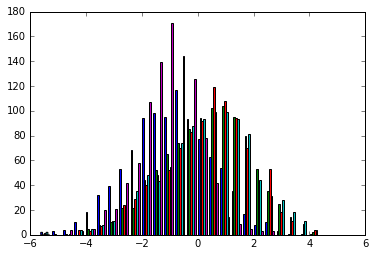

In [13]:
# plot histogram of raw features
plt.hist(features, bins='auto') 
plt.show()

In [14]:
# preprocessed data by scaling
#    - center to the mean and component wise scale to unit variance
features = preprocessing.scale(features)
features

array([[ 0.20229658, -0.18407579,  0.86358738,  1.02862505,  0.36704269],
       [-3.11987964, -0.14726649, -1.85029874, -0.14137452, -1.83713649],
       [-0.07963194,  0.39933055,  0.17253459, -0.97613908,  0.11755125],
       ..., 
       [ 0.6697901 ,  1.48600131,  0.80093587, -1.57897902, -1.52302191],
       [ 1.09342236, -0.35652121, -1.25870483,  0.50071707,  1.58913865],
       [-0.11027079, -1.03622262, -0.6990843 , -0.72091252,  0.72715004]])

In [15]:
# statistical summary after scaling features
fdf = pd.DataFrame(features, columns=['F1','F2','F3','F4','F5'])
fdf.describe()

,F1,F2,F3,F4,F5
count,9.950000e+02,9.950000e+02,9.950000e+02,9.950000e+02,9.950000e+02
mean,-3.124246e-18,5.355850e-18,-5.467430e-18,-4.452050e-17,-6.003015e-17
std,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00
min,-3.119880e+00,-3.428137e+00,-3.590793e+00,-3.961662e+00,-4.646592e+00
25%,-6.737910e-01,-6.720263e-01,-6.338349e-01,-6.220118e-01,-5.841072e-01
50%,2.669413e-02,7.234548e-02,8.177067e-02,8.035517e-02,3.438654e-02
75%,6.705913e-01,7.122422e-01,6.718715e-01,6.807934e-01,6.542726e-01
max,3.545606e+00,3.194924e+00,3.431496e+00,2.684867e+00,3.545858e+00


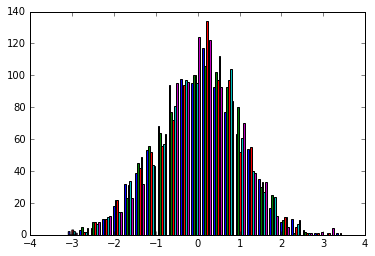

In [16]:
# plot histogram of preprocessed features
plt.hist(features, bins='auto') 
plt.show()

Features Scatter Plot


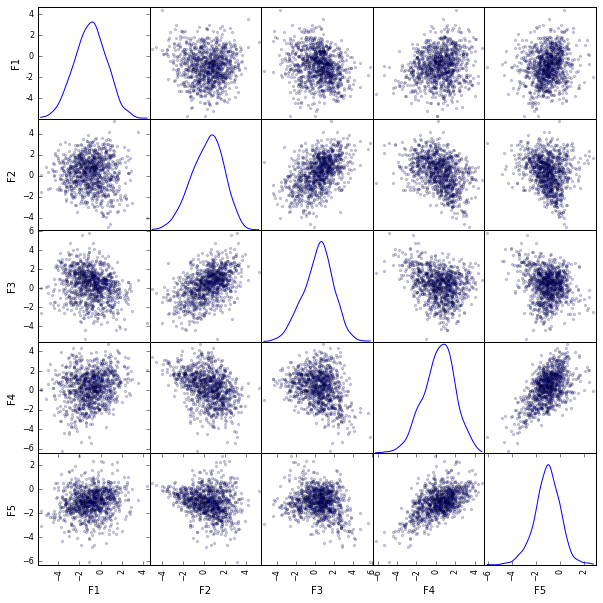

In [17]:
# plot scatter matrix for features
from pandas.tools.plotting import scatter_matrix

fdf = cdf[['F1','F2','F3','F4','F5']]
scatter_matrix(fdf, alpha=0.2, figsize=(10, 10), diagonal='kde')
print 'Features Scatter Plot'

In [52]:
# split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(features, 
                                                                              targets, 
                                                                              test_size=0.33, 
                                                                              random_state=42)
print "features_train:\n", features_train, "\n"
print "targets_train:\n", targets_train[:100], "\n"
print "features_test:\n", features_test, "\n"
print "targets_test:\n", targets_test[:100]

features_train:
[[-0.51224375  0.42243955 -0.50857671 -0.04424938 -0.34347719]
 [ 0.57550736 -0.58351094 -0.74855335 -0.14414659  0.30611032]
 [-0.46391385 -0.63222036 -2.20025747  0.08958242 -0.79321154]
 ..., 
 [ 0.95088212  1.29843256  0.29791215 -0.29712341 -0.38446396]
 [-0.23170288  1.22581249  0.13327262 -0.89405371  0.27547357]
 [-1.4447093  -0.60344625 -0.44578658  0.52319009 -0.42583136]] 

targets_train:
[ 1.  1.  1.  0.  1.  2.  1.  1.  0.  2.  0.  1.  0.  0.  0.  2.  0.  0.
  2.  0.  1.  1.  1.  1.  1.  1.  2.  0.  2.  1.  1.  0.  2.  2.  1.  2.
  2.  0.  2.  1.  2.  1.  0.  1.  1.  2.  2.  2.  0.  0.  2.  2.  2.  1.
  1.  1.  2.  2.  1.  2.  2.  0.  1.  2.  2.  1.  2.  2.  2.  0.  0.  2.
  2.  0.  2.  0.  1.  0.  1.  2.  1.  2.  1.  1.  2.  0.  0.  0.  1.  2.
  2.  0.  0.  0.  2.  1.  0.  2.  0.  1.] 

features_test:
[[-0.89270437  0.04055773 -1.15321384 -0.30528675 -0.6530195 ]
 [-0.87324173 -0.19396718 -0.59368648 -0.32476991 -0.3092854 ]
 [ 0.63234815 -1.90412092 -0.62

## create SVM model

In [53]:
# create a linear SVM classifier
clf = SVC(C=0.01, kernel='linear', decision_function_shape=None, probability=True)

In [54]:
# get model parameters
clf.get_params(deep=True)

{'C': 0.01,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [55]:
# fit the SVM model according to the given training data
clf.fit(features_train, targets_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
# get distance of the samples features to the separating hyperplane
clf.decision_function(features_train)

array([[ 0.07881673,  0.52144339,  0.1412611 ],
       [-0.48384628, -0.06252866,  0.2567693 ],
       [-1.81791811,  1.08688641,  1.52901215],
       ..., 
       [ 1.80881864, -0.07713455, -0.97531432],
       [ 1.09881128, -0.77816819, -1.31745505],
       [-0.95072896,  1.29223711,  1.15242126]])

In [57]:
# support vector shape
# note: need to reduce the number of support vectors for this model
clf.support_vectors_.shape

(528, 5)

In [58]:
# assigned feature weights
clf.coef_

array([[ 0.37645164,  0.7906424 ,  0.65337363,  0.16047852, -0.00612053],
       [-0.17653491,  0.00478585, -0.13186712,  1.02073621, -0.48770645],
       [-0.15472494, -0.4534248 , -0.40472731,  0.70835298, -0.30584807]])

In [59]:
# perform classification on test samples
predictions = clf.predict(features_test)
predictions[:100]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  2.,  2.,  2.,  2.,  0.,  2.,  0.,  2.,  2.,  0.,
        1.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  1.,  2.,  1.,  2.,
        1.,  0.,  2.,  1.,  0.,  1.,  2.,  2.,  2.,  1.,  1.,  2.,  2.,
        2.,  2.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  2.,  1.,
        0.,  2.,  0.,  2.,  2.,  2.,  1.,  0.,  2.,  0.,  2.,  1.,  2.,
        2.,  1.,  2.,  0.,  2.,  1.,  2.,  2.,  0.,  2.,  2.,  0.,  1.,
        2.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.])

In [60]:
# compute probabilities of possible outcomes on test samples
clf.predict_proba(features_test)[:10]

array([[  1.55077642e-02,   9.40277970e-01,   4.42142662e-02],
       [  4.99898649e-02,   8.35533873e-01,   1.14476262e-01],
       [  2.41835858e-03,   9.97463910e-01,   1.17731351e-04],
       [  1.08179949e-02,   9.88974959e-01,   2.07045690e-04],
       [  6.83763602e-02,   8.05374625e-01,   1.26249015e-01],
       [  4.43625367e-02,   8.37679717e-01,   1.17957746e-01],
       [  6.61174276e-02,   5.56532249e-02,   8.78229348e-01],
       [  7.42246907e-08,   9.99864052e-01,   1.35874198e-04],
       [  1.51409299e-02,   9.81306927e-01,   3.55214292e-03],
       [  5.47807054e-03,   9.87920550e-01,   6.60137984e-03]])

In [62]:
# find the number of successful targets
np.sum(predictions == targets_test)

268

In [63]:
# summarize the fit of the model: classification report
expected = targets_test
predicted = clf.predict(features_test)
print metrics.classification_report(expected, predicted)

             precision    recall  f1-score   support

        0.0       0.80      0.71      0.76       104
        1.0       0.89      0.87      0.88       113
        2.0       0.76      0.86      0.80       112

avg / total       0.82      0.81      0.81       329



In [64]:
# summarize the fit of the model: confusion matrix
print metrics.confusion_matrix(expected, predicted)

[[74  5 25]
 [ 9 98  6]
 [ 9  7 96]]


## save customerIssue model

In [65]:
from sklearn.externals import joblib

joblib.dump(clf, 'customerIssueModel.pkl', compress=9)

['customerIssueModel.pkl']

## test saved model

In [66]:
# get saved model
savedModel = joblib.load('customerIssueModel.pkl')
savedModel

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
# display original model
clf

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
# check the current model feature weights
clf.coef_

array([[ 0.37645164,  0.7906424 ,  0.65337363,  0.16047852, -0.00612053],
       [-0.17653491,  0.00478585, -0.13186712,  1.02073621, -0.48770645],
       [-0.15472494, -0.4534248 , -0.40472731,  0.70835298, -0.30584807]])

In [69]:
# check the saved model feature weights
savedModel.coef_

array([[ 0.37645164,  0.7906424 ,  0.65337363,  0.16047852, -0.00612053],
       [-0.17653491,  0.00478585, -0.13186712,  1.02073621, -0.48770645],
       [-0.15472494, -0.4534248 , -0.40472731,  0.70835298, -0.30584807]])